# B1: Tiền xử lý dữ liệu

In [8]:
import pandas as pd
import re

# Đọc dữ liệu
df = pd.read_csv("../input/tweets-sentiment-analysis/train_data.csv", encoding='latin-1')  # KHÔNG cần header=None

# Kiểm tra nhanh
print(df.head())
print(df["sentiment"].value_counts())

# Làm sạch văn bản
def clean_text(text):
    text = re.sub(r"http\S+|@\S+|[^a-zA-Z\s]", "", str(text))  # loại link, @, kí tự đặc biệt
    return text.lower()

df["sentence"] = df["sentence"].apply(clean_text)


                                            sentence  sentiment
0  awww that s a bummer you shoulda got david car...          0
1  is upset that he can t update his facebook by ...          0
2  i dived many times for the ball managed to sav...          0
3     my whole body feels itchy and like its on fire          0
4  no it s not behaving at all i m mad why am i h...          0
sentiment
0    767059
1    756916
Name: count, dtype: int64


# B2: Tách tập train/test

In [11]:
from sklearn.model_selection import train_test_split

X = df["sentence"].values
y = df["sentiment"].values  # nhãn: 0 hoặc 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# B3: Tokenizer & Padding

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


2025-06-19 04:41:39.573412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750308099.779987      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750308099.845226      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# B4: Xây dựng mô hình (Embedding → FCN)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=16, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # đầu ra nhị phân
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# B5: Huấn luyện mô hình

In [16]:
epochs = 10
batch_size = 128

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=epochs,
    batch_size=batch_size
)


Epoch 1/10


I0000 00:00:1750308170.568012     106 service.cc:148] XLA service 0x7defe4014960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750308170.568507     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750308170.901705     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  76/9525 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.4979 - loss: 0.6936 

I0000 00:00:1750308171.717900     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9525/9525 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7088 - loss: 0.5575 - val_accuracy: 0.7906 - val_loss: 0.4725
Epoch 2/10
9525/9525 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7838 - loss: 0.4735 - val_accuracy: 0.7924 - val_loss: 0.4589
Epoch 3/10
9525/9525 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.7891 - loss: 0.4563 - val_accuracy: 0.7835 - val_loss: 0.4582
Epoch 4/10
9525/9525 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.7929 - loss: 0.4445 - val_accuracy: 0.7825 - val_loss: 0.4582
Epoch 5/10
9525/9525 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7935 - loss: 0.4405 - val_accuracy: 0.7947 - val_loss: 0.4389
Epoch 6/10
9525/9525 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7949 - loss: 0.4373 - val_accuracy: 0.7945 - val_loss: 0.4400
Epoch 7/10
9525/9525 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7973 - loss: 0.4336 - val_accuracy: 0.7981 - val_loss: 0.4340
Epoch 8/10
9525/9525 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7998 - loss: 0.4294 - val

# B6: Đánh giá kết quả

In [19]:
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%") # >= 75% là đạt


9525/9525 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7956 - loss: 0.4377
Test Accuracy: 79.62%


# B7: Vẽ biểu đồ độ chính xác và mất mát (tùy chọn)

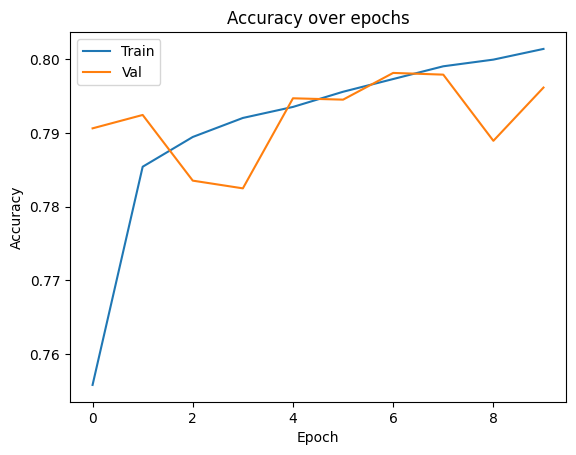

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
